# Ratelaw API

`modelbase 1.0` re-introduces the ratelaw api, albeit in a changed format. To see this, let us first take a look at how they are constructed internally.

Each rate law class should inherit from the BaseRateLaw, which is an abstract base class. The functions a rate law has to define are `get_sbml_function_string` and `get_rate_function`. These two are used during the reaction construction via `add_reaction_from_ratelaw`. The rate law also has to fill the attributes `substrates`, `products`, `modifiers`, `parameters`, `stoichiometry` and `reversible`, although they can be kept at their default state if not applicable to the rate law.

In [1]:
import matplotlib.pyplot as plt

from modelbase.ode import Model, Simulator
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

Could not find GLIMDA.


In [2]:
from abc import ABC, abstractmethod


class BaseRateLaw(ABC):
    def __init__(self):
        self.substrates = []
        self.products = []
        self.modifiers = []
        self.parameters = []
        self.stoichiometry = {}
        self.reversible = False

    @abstractmethod
    def get_sbml_function_string(self):
        pass

    @abstractmethod
    def get_rate_function(self):
        pass

If needed, other attributes can be added, e.g. for making the construction of the function string more readable.

In [3]:
class MichaelisMenten(BaseRateLaw):
    def __init__(self, S, P, vmax, km):
        super().__init__()
        self.substrates = [S]
        self.products = [P]
        self.parameters = [vmax, km]
        self.stoichiometry = {S: -1, P: 1}

        self.S = S
        self.vmax = vmax
        self.km = km

    def get_sbml_function_string(self):
        return f"{self.S} * {self.vmax} / ({self.S} + {self.km})"

    def get_rate_function(self):
        return rf.michaelis_menten

The rate function should be added to `modelbase.ode.utils.ratefunctions`, such that they are also callable if the RateLaw functionality is not required. In that way flexible constructors, for e.g. MassAction kinetics can still be implemented.

In [4]:
class MassAction(BaseRateLaw):
    def __init__(self, substrates, products, k_fwd):
        super().__init__()
        self.substrates = substrates
        self.products = products
        self.parameters = [k_fwd]
        self.stoichiometry = _pack_stoichiometries(substrates, products)

        self.k_fwd = k_fwd

    def get_sbml_function_string(self):
        return f"{self.k_fwd} * {' * '.join(self.substrates)}"

    def get_rate_function(self):
        return getattr(ratefunctions, f"mass_action_{len(self.substrates)}")

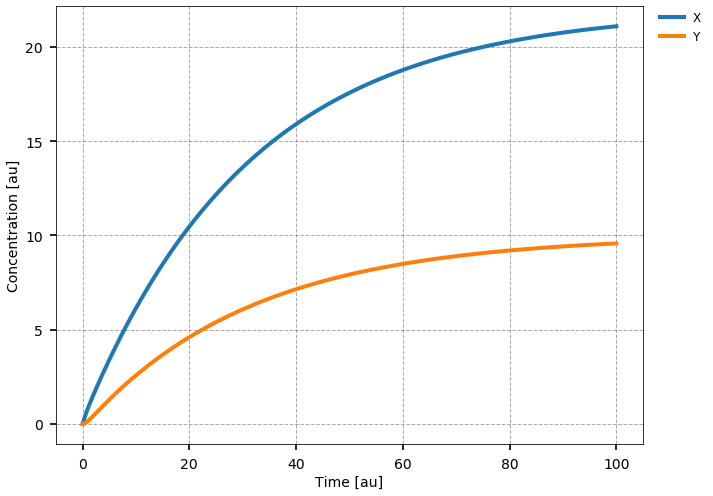

In [5]:
m = Model()
m.add_parameters({"v0": 1, "k1p": 0.5, "k1m": 1, "k2": 0.1})
m.add_compounds(["X", "Y"])
m.add_reaction_from_ratelaw(rate_name="v0", ratelaw=rl.Constant(product="X", k="v0"))
m.add_reaction_from_ratelaw(
    rate_name="v1",
    ratelaw=rl.ReversibleMassAction(
        substrates=["X"], products=["Y"], k_fwd="k1p", k_bwd="k1m"
    ),
)
m.add_reaction_from_ratelaw(
    rate_name="v2", ratelaw=rl.MassAction(substrates=["Y"], products=[], k_fwd="k2")
)

s = Simulator(m)
s.initialise({"X": 0, "Y": 0})
t, y = s.simulate(100)
fig, ax = s.plot(xlabel="Time [au]", ylabel="Concentration [au]")
plt.show()

The RateLaw API enables us to have SBML export of the rate functions themselves. 

In [6]:
m.meta_info['rates']

{'v0': Rate(common_name=None, gibbs0=None, ec=None, database_links={}, notes={}, sbml_function='v0'),
 'v1': Rate(common_name=None, gibbs0=None, ec=None, database_links={}, notes={}, sbml_function='k1p * X - k1m * Y'),
 'v2': Rate(common_name=None, gibbs0=None, ec=None, database_links={}, notes={}, sbml_function='k2 * Y')}

If such an export is wanted without using the API, compounds, rates and reactions can now take `meta_info` kwargs

In [7]:
m = Model()
m.add_compound(
    "x",
    **{
        "common_name": "RuBP",
        "database_links": {"kegg": "kegg_id", "metacyc": "metacyc_id"},
    }
)
m.add_rate("v1", lambda *args: 0, **{"common_name": "RuBisCO"})

In [8]:
m.meta_info['compounds']

{'x': Compound(common_name='RuBP', compartment='c', formula=None, charge=None, gibbs0=None, smiles=None, database_links={'kegg': 'kegg_id', 'metacyc': 'metacyc_id'}, notes={})}

In [9]:
m.meta_info['rates']

{'v1': Rate(common_name='RuBisCO', gibbs0=None, ec=None, database_links={}, notes={}, sbml_function=None)}